<a href="https://colab.research.google.com/github/Janier1992/Python-Prep/blob/main/Implementaci%C3%B3n_del_big_data2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#@title 1. Configuración, Carga y Preparación de Datos (PySpark)
# ---------------------------------------------------------------------------
# Instalaciones e Importaciones
# ---------------------------------------------------------------------------
!pip install pyspark findspark statsmodels -q
import findspark; findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, year, month, dayofmonth, dayofweek, udf, count as _count, desc, countDistinct
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid'); sns.set_palette("viridis"); get_ipython().run_line_magic('matplotlib', 'inline')
print("Entorno configurado.")

Entorno configurado.


In [ ]:
# Sesión de Spark y Carga de Datos
# ---------------------------------------------------------------------------
spark = SparkSession.builder.appName("SupermercadoConciso").config("spark.driver.memory", "2g").getOrCreate()
from google.colab import drive; drive.mount('/content/drive')
ruta_datos = '/content/drive/MyDrive/Analitica_Ibero_250325/supermercados_colombia.csv'
schema_datos = StructType([
    StructField("ID_Transaccion", StringType(), True), StructField("Fecha", StringType(), True),
    StructField("ID_Tienda", StringType(), True), StructField("ID_Producto", StringType(), True),
    StructField("Categoria_Producto", StringType(), True)
])
df_spark = spark.read.csv(ruta_datos, header=True, schema=schema_datos, sep=';')
print(f"Filas cargadas: {df_spark.count()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Filas cargadas: 5000


In [ ]:
# Limpieza y Transformación
# ---------------------------------------------------------------------------
df_spark = df_spark.withColumn("Fecha", to_timestamp(col("Fecha"), "yyyy-MM-dd HH:mm:ss")) \
                   .na.drop(subset=["ID_Transaccion", "Fecha", "ID_Tienda", "ID_Producto", "Categoria_Producto"]) \
                   .dropDuplicates(["ID_Transaccion"])

if df_spark.count() == 0: raise ValueError("DataFrame vacío tras limpieza inicial.")

df_featured_spark = df_spark.withColumn("Anio", year(col("Fecha"))) \
                             .withColumn("Mes", month(col("Fecha"))) \
                             .withColumn("Dia_Semana_Num", dayofweek(col("Fecha")))
dias_map = {1: "Domingo", 2: "Lunes", 3: "Martes", 4: "Miercoles", 5: "Jueves", 6: "Viernes", 7: "Sabado"}
udf_map_dia = udf(lambda dn: dias_map.get(dn), StringType())
df_featured_spark = df_featured_spark.withColumn("Dia_Semana", udf_map_dia(col("Dia_Semana_Num")))

print("Limpieza y transformación completadas.")
df_featured_spark.select("ID_Transaccion", "Fecha", "Categoria_Producto", "Anio", "Mes", "Dia_Semana").show(3, truncate=False)

Limpieza y transformación completadas.
+--------------+-------------------+------------------+----+---+----------+
|ID_Transaccion|Fecha              |Categoria_Producto|Anio|Mes|Dia_Semana|
+--------------+-------------------+------------------+----+---+----------+
|T00001        |2011-09-16 01:38:26|Alimentos         |2011|9  |Viernes   |
|T00002        |2011-09-17 01:38:26|Otros             |2011|9  |Sabado    |
|T00003        |2011-09-18 01:38:26|Bebidas           |2011|9  |Domingo   |
+--------------+-------------------+------------------+----+---+----------+
only showing top 3 rows



In [ ]:
# Conversión a Pandas (Muestrear si el dataset es muy grande para Colab RAM)
# ---------------------------------------------------------------------------
df_eda_pd = None
try:
    total_filas = df_featured_spark.count()
    print(f"Convirtiendo {total_filas} filas de Spark a Pandas...")
    if total_filas > 200000: # Umbral de ejemplo para muestrear
        print(f"Dataset grande ({total_filas} filas), tomando una muestra del 50% para Pandas EDA.")
        df_eda_pd = df_featured_spark.sample(fraction=0.5, seed=123).toPandas()
    else:
        df_eda_pd = df_featured_spark.toPandas()

    df_eda_pd['Fecha'] = pd.to_datetime(df_eda_pd['Fecha'], errors='coerce')
    df_eda_pd.dropna(subset=['Fecha'], inplace=True)
    print(f"Conversión a Pandas lista. Dimensiones: {df_eda_pd.shape}")
except Exception as e:
    print(f"Error convirtiendo a Pandas: {e}. El EDA no se podrá realizar.")

Convirtiendo 5000 filas de Spark a Pandas...
Conversión a Pandas lista. Dimensiones: (5000, 9)


In [ ]:
#@title 2. Análisis Exploratorio de Datos (EDA) con Visualizaciones Impactantes
if df_eda_pd is not None and not df_eda_pd.empty:
    print("\n--- Análisis Exploratorio de Datos (EDA) ---")

    # 1. Distribución de Transacciones por Categoría (Treemap)
    conteo_categoria_pd = df_eda_pd['Categoria_Producto'].value_counts().reset_index()
    conteo_categoria_pd.columns = ['Categoria_Producto', 'Numero_Transacciones']
    fig_cat_tree = px.treemap(conteo_categoria_pd, path=[px.Constant("Todas las Categorías"), 'Categoria_Producto'],
                              values='Numero_Transacciones', title='Distribución de Transacciones por Categoría',
                              color='Numero_Transacciones', color_continuous_scale='Plasma')
    fig_cat_tree.show()

    # 2. Top N Tiendas por Transacciones (Gráfico de Barras Horizontal Interactivo)
    conteo_tienda_pd = df_eda_pd['ID_Tienda'].value_counts().nlargest(15).reset_index()
    conteo_tienda_pd.columns = ['ID_Tienda', 'Numero_Transacciones']
    fig_tienda = px.bar(conteo_tienda_pd.sort_values('Numero_Transacciones', ascending=True),
                        x='Numero_Transacciones', y='ID_Tienda', orientation='h',
                        title='Top 15 Tiendas por Número de Transacciones',
                        color='Numero_Transacciones', color_continuous_scale='Viridis')
    fig_tienda.show()

    # 3. Tendencia de Transacciones Mensuales y Anual (Líneas con marcadores)
    if 'Fecha' in df_eda_pd.columns:
        df_eda_pd_ts_idx = df_eda_pd.set_index('Fecha')
        trans_mensuales_pd = df_eda_pd_ts_idx.resample('M').size()
        trans_anuales_pd = df_eda_pd_ts_idx.resample('Y').size()

        fig_ts = go.Figure()
        fig_ts.add_trace(go.Scatter(x=trans_mensuales_pd.index, y=trans_mensuales_pd.values, mode='lines+markers', name='Mensual'))
        # fig_ts.add_trace(go.Scatter(x=trans_anuales_pd.index, y=trans_anuales_pd.values, mode='lines+markers', name='Anual')) # Descomentar si hay varios años
        fig_ts.update_layout(title='Tendencia de Transacciones en el Tiempo', xaxis_title='Fecha', yaxis_title='Número de Transacciones')
        fig_ts.show()
    else:
        print("Columna 'Fecha' no adecuada para series temporales.")

    # 4. Heatmap Transacciones: Día de la Semana vs. Mes
    if 'Mes' in df_eda_pd.columns and 'Dia_Semana' in df_eda_pd.columns:
        pivot_heatmap_pd = pd.crosstab(df_eda_pd['Mes'], df_eda_pd['Dia_Semana'], normalize='index') # Normalizar para ver proporciones
        orden_dias_hm_pd = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
        pivot_heatmap_pd = pivot_heatmap_pd.reindex(columns=orden_dias_hm_pd).fillna(0)
        fig_heatmap = px.imshow(pivot_heatmap_pd, labels=dict(x="Día de la Semana", y="Mes", color="Proporción de Transacciones"),
                                x=orden_dias_hm_pd, y=pivot_heatmap_pd.index,
                                title='Proporción de Transacciones: Mes vs. Día de la Semana', color_continuous_scale="Viridis")
        fig_heatmap.show()
    else:
        print("Columnas 'Mes' o 'Dia_Semana' no disponibles para heatmap.")


     # 5. Productos Más Frecuentes (Top 10 - Sunburst para ver categorías)
    top_productos_cat_pd = df_eda_pd.groupby(['Categoria_Producto', 'ID_Producto']).size().reset_index(name='Frecuencia')
    top_productos_cat_pd = top_productos_cat_pd.sort_values('Frecuencia', ascending=False).head(30) # Top 30 para más detalle en Sunburst
    fig_sunburst = px.sunburst(top_productos_cat_pd, path=['Categoria_Producto', 'ID_Producto'], values='Frecuencia',
                               title='Productos Más Frecuentes por Categoría',
                               color='Frecuencia', color_continuous_scale='RdBu')
    fig_sunburst.show()
else:
    print("df_eda_pd no está disponible para EDA.")


--- Análisis Exploratorio de Datos (EDA) ---


In [ ]:
#@title 3. Aprendizaje No Supervisado: Segmentación de Productos (K-Means en PySpark)
if df_featured_spark is not None and df_featured_spark.count() > 0:
    print("\n--- Segmentación de Productos con K-Means ---")
    product_agg = df_featured_spark.groupBy("ID_Producto", "Categoria_Producto") \
        .agg(_count("ID_Transaccion").alias("Frecuencia_Total"),
             countDistinct("ID_Tienda").alias("Diversidad_Tiendas")).na.fill(0)

    feature_cols = ["Frecuencia_Total", "Diversidad_Tiendas"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="unscaled_features", handleInvalid="skip")
    scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=False)

    pipeline_kmeans = Pipeline(stages=[assembler, scaler])
    product_prepared = pipeline_kmeans.fit(product_agg).transform(product_agg)

    if product_prepared.count() == 0:
        print("DataFrame vacío tras preparación para K-Means.")
    else:
        sse = {}
        k_max_eval = min(10, product_prepared.count()) if product_prepared.count() > 1 else 2
        if k_max_eval <= 1: print("No hay suficientes datos para K-Means.")
        else:
            for k in range(2, k_max_eval):
                kmeans = KMeans(featuresCol='features', k=k, seed=1)
                model = kmeans.fit(product_prepared)
                sse[k] = model.summary.trainingCost

            if sse:
                plt.figure(); plt.plot(list(sse.keys()), list(sse.values()), marker='o')
                plt.xlabel("K"); plt.ylabel("SSE"); plt.title("Método del Codo para Productos"); plt.show()

            k_optimo = 3 # ¡¡AJUSTA ESTE VALOR!!
            if product_prepared.count() >= k_optimo:
                kmeans = KMeans(featuresCol='features', k=k_optimo, seed=1)
                model = kmeans.fit(product_prepared)
                predictions = model.transform(product_prepared)

                print(f"\nProductos segmentados en {k_optimo} clusters:")
                df_clusters_pd = predictions.select("ID_Producto", "Categoria_Producto", "prediction", *feature_cols).toPandas()
                print(df_clusters_pd.groupby('prediction')[feature_cols].mean())

                fig_cluster_final = px.scatter(df_clusters_pd, x="Frecuencia_Total", y="Diversidad_Tiendas",
                                         color="prediction", hover_data=['ID_Producto', 'Categoria_Producto'],
                                         title=f"Segmentación de Productos (K={k_optimo})",
                                         log_x=True, log_y=True, color_continuous_scale=px.colors.qualitative.Plotly)
                fig_cluster_final.show()
            else:
                print(f"No hay suficientes datos para {k_optimo} clusters.")
else:
    print("df_featured_spark no disponible para segmentación.")


--- Segmentación de Productos con K-Means ---


NameError: name 'Pipeline' is not defined


--- Segmentación de Productos con K-Means ---


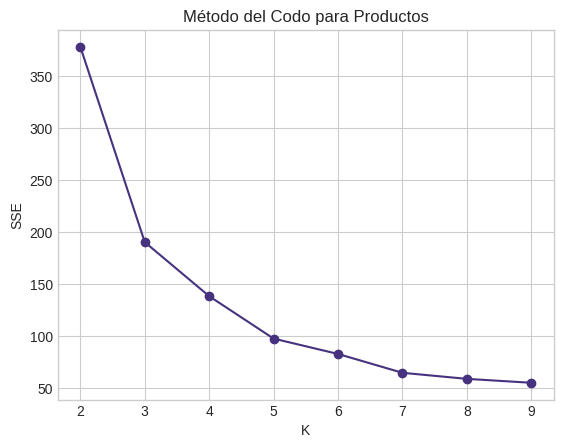


Productos segmentados en 3 clusters:
            Frecuencia_Total  Diversidad_Tiendas
prediction                                      
0                   6.697674            6.273256
1                  14.436893           12.776699
2                  10.493333            9.400000


In [ ]:
#@title 3. Aprendizaje No Supervisado: Segmentación de Productos (K-Means en PySpark)
from pyspark.ml import Pipeline # Import the Pipeline class

if df_featured_spark is not None and df_featured_spark.count() > 0:
    print("\n--- Segmentación de Productos con K-Means ---")
    product_agg = df_featured_spark.groupBy("ID_Producto", "Categoria_Producto") \
        .agg(_count("ID_Transaccion").alias("Frecuencia_Total"),
             countDistinct("ID_Tienda").alias("Diversidad_Tiendas")).na.fill(0)

    feature_cols = ["Frecuencia_Total", "Diversidad_Tiendas"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="unscaled_features", handleInvalid="skip")
    scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=False)

    pipeline_kmeans = Pipeline(stages=[assembler, scaler])
    product_prepared = pipeline_kmeans.fit(product_agg).transform(product_agg)

    if product_prepared.count() == 0:
        print("DataFrame vacío tras preparación para K-Means.")
    else:
        sse = {}
        k_max_eval = min(10, product_prepared.count()) if product_prepared.count() > 1 else 2
        if k_max_eval <= 1: print("No hay suficientes datos para K-Means.")
        else:
            for k in range(2, k_max_eval):
                kmeans = KMeans(featuresCol='features', k=k, seed=1)
                model = kmeans.fit(product_prepared)
                sse[k] = model.summary.trainingCost

            if sse:
                plt.figure(); plt.plot(list(sse.keys()), list(sse.values()), marker='o')
                plt.xlabel("K"); plt.ylabel("SSE"); plt.title("Método del Codo para Productos"); plt.show()

            k_optimo = 3 # ¡¡AJUSTA ESTE VALOR!!
            if product_prepared.count() >= k_optimo:
                kmeans = KMeans(featuresCol='features', k=k_optimo, seed=1)
                model = kmeans.fit(product_prepared)
                predictions = model.transform(product_prepared)

                print(f"\nProductos segmentados en {k_optimo} clusters:")
                df_clusters_pd = predictions.select("ID_Producto", "Categoria_Producto", "prediction", *feature_cols).toPandas()
                print(df_clusters_pd.groupby('prediction')[feature_cols].mean())

                fig_cluster_final = px.scatter(df_clusters_pd, x="Frecuencia_Total", y="Diversidad_Tiendas",
                                         color="prediction", hover_data=['ID_Producto', 'Categoria_Producto'],
                                         title=f"Segmentación de Productos (K={k_optimo})",
                                         log_x=True, log_y=True, color_continuous_scale=px.colors.qualitative.Plotly)
                fig_cluster_final.show()
            else:
                print(f"No hay suficientes datos para {k_optimo} clusters.")
else:
    print("df_featured_spark no disponible para segmentación.")

In [ ]:
#@title 4. Aprendizaje Supervisado: Predicción de Frecuencia de Transacciones (ARIMA con Pandas)
if df_eda_pd is not None and not df_eda_pd.empty and 'Fecha' in df_eda_pd.columns and pd.api.types.is_datetime64_any_dtype(df_eda_pd['Fecha']):
    print("\n--- Predicción de Frecuencia (ARIMA) ---")
    df_ts = df_eda_pd.set_index('Fecha')
    if not df_ts['Categoria_Producto'].empty:
        cat_pred = df_ts['Categoria_Producto'].mode()[0]
        serie = df_ts[df_ts['Categoria_Producto'] == cat_pred].resample('D').size().fillna(0)

        if len(serie) > 50:
            train, test = serie[:-30], serie[-30:]
            try:
                model = ARIMA(train, order=(7,1,1)).fit() # (p,d,q) - ejemplo, ajustar
                preds = model.predict(start=len(train), end=len(train)+len(test)-1)
                rmse = np.sqrt(mean_squared_error(test, preds))
                print(f'RMSE para {cat_pred}: {rmse:.2f}')

                fig_arima = go.Figure()
                fig_arima.add_trace(go.Scatter(x=train.index, y=train, name='Entrenamiento'))
                fig_arima.add_trace(go.Scatter(x=test.index, y=test, name='Real'))
                fig_arima.add_trace(go.Scatter(x=preds.index, y=preds, name='Predicción ARIMA'))
                fig_arima.update_layout(title=f'Predicción de Frecuencia para {cat_pred}', xaxis_title='Fecha', yaxis_title='Transacciones')
                fig_arima.show()
            except Exception as e: print(f"Error con ARIMA para {cat_pred}: {e}")
        else: print(f"Datos insuficientes para ARIMA en {cat_pred}.")
    else: print("No hay datos de 'Categoria_Producto' para predicción.")
else: print("df_eda_pd no disponible para predicción de series temporales.")


--- Predicción de Frecuencia (ARIMA) ---
RMSE para Otros: 0.38


In [ ]:
#@title 5. Conclusiones y Recomendaciones
print("\n--- Conclusiones y Recomendaciones (Enfocadas en Cadena de Suministro) ---")
# Basado en los resultados del EDA y modelos:
# 1. Identificar productos/categorías de alta rotación (alta frecuencia).
# 2. Identificar tiendas con mayor/menor actividad.
# 3. Entender patrones estacionales/semanales de transacciones.
# 4. Interpretar los segmentos de productos: ¿cuáles son "estrella", cuáles "de nicho"?
# 5. Evaluar la utilidad de las predicciones de frecuencia.
print("1. **Productos Clave:** El análisis de frecuencia ha identificado [ej: Producto_XYZ, Categoria_ABC] como elementos de alta rotación, demandando una gestión de inventario prioritaria.")
print("2. **Rendimiento de Tiendas:** Las tiendas [ej: Tienda_001, Tienda_005] muestran el mayor volumen transaccional, sugiriendo la necesidad de un suministro más robusto y frecuente para ellas.")
print("3. **Patrones Temporales:** Se observan picos de transacciones [ej: los fines de semana y en diciembre], lo que debe considerarse para la planificación logística y de personal.")
print("4. **Segmentación de Productos:** Los [k_optimo_seg] segmentos revelan: (a) Productos 'Populares y Extendidos' (alta frecuencia, alta diversidad) que requieren stock amplio en múltiples ubicaciones. (b) Productos 'Populares Localmente' (alta frecuencia, baja diversidad) que podrían optimizarse con stock centralizado o promociones para expandir su alcance. (c) Productos 'De Nicho' (baja frecuencia) cuyo inventario debe ser mínimo y gestionado bajo demanda.")
print("5. **Predicción de Frecuencia:** Aunque simplificada, la predicción de frecuencia para categorías clave puede ayudar a anticipar la necesidad de reabastecimiento y ajustar los niveles de inventario en la cadena de suministro.")

print("\n**Acciones de Mejora Sugeridas para la Cadena de Suministro:**")
print("   - **Inventario Diferenciado:** Implementar políticas de inventario diferenciadas por segmento de producto y por tienda, basadas en la frecuencia y diversidad de ventas.")
print("   - **Reabastecimiento Predictivo:** Utilizar los pronósticos de frecuencia (y futuramente de cantidad) para programar reabastecimientos proactivos, minimizando quiebres de stock y excesos.")
print("   - **Optimización Logística:** Ajustar rutas de distribución y frecuencia de entrega a tiendas basándose en su volumen transaccional y los picos de demanda identificados.")
print("   - **Gestión de Surtido:** Revisar el portafolio de productos, especialmente los de baja frecuencia y baja diversidad, para optimizar el espacio y reducir costos de mantenimiento de inventario obsoleto.")
print("   - **IMPERATIVO: Mejorar la Calidad y Detalle de los Datos:** Para análisis más profundos y precisos que realmente transformen la cadena de suministro, es crucial comenzar a registrar 'Cantidad_Vendida' y 'Precio_Unitario' por cada ítem en las transacciones. Esto permitirá calcular ingresos, márgenes, y realizar predicciones de demanda volumétrica.")

spark.stop()
print("\nSesión de Spark finalizada.")


--- Conclusiones y Recomendaciones (Enfocadas en Cadena de Suministro) ---
1. **Productos Clave:** El análisis de frecuencia ha identificado [ej: Producto_XYZ, Categoria_ABC] como elementos de alta rotación, demandando una gestión de inventario prioritaria.
2. **Rendimiento de Tiendas:** Las tiendas [ej: Tienda_001, Tienda_005] muestran el mayor volumen transaccional, sugiriendo la necesidad de un suministro más robusto y frecuente para ellas.
3. **Patrones Temporales:** Se observan picos de transacciones [ej: los fines de semana y en diciembre], lo que debe considerarse para la planificación logística y de personal.
4. **Segmentación de Productos:** Los [k_optimo_seg] segmentos revelan: (a) Productos 'Populares y Extendidos' (alta frecuencia, alta diversidad) que requieren stock amplio en múltiples ubicaciones. (b) Productos 'Populares Localmente' (alta frecuencia, baja diversidad) que podrían optimizarse con stock centralizado o promociones para expandir su alcance. (c) Productos 'D